In [3]:
# Set up functions to return the campaign results
# Import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#First, we'll write the function for running our marketing campaign

# Here, we're trying to measure the outcome of whether or not the potential customer signed up, or converted

# Given this, we can use a binomial distribution to model our campaign
# We can divide our spend (budget) by our CPM (cost per 1000 impressions- i.e ad load)
# to determine the number of trials for our campaign. 

# The conversion rate is simply the probability of success

# Function for calculating the results of a marketing campaign

def run_campaign(spend, cpm, conversion_rate):
    return np.random.binomial(spend/cpm*1000, conversion_rate)

In [5]:
# Next, we can model our conversion rate (the probability of success). 
# Here we'll just use a normal distribution, with a floor of ~0 since

# it's not possible to have a negative conversion rate

def get_conversion_rate(expected, stdev):
    conversion_rate = max(expected + np.random.normal()*stdev, 
                          0.000001)
    return conversion_rate

In [6]:
# Next, we'll set up some marketing campaign inputs:
# Budget

spend = 50000

# Cost per thousand impressions
cpm = 2

# Expected conversion rate, variance

conversion_rate_expected = 0.00005 # per impression, not click

conversion_rate_stdev = 0.00002 

In [15]:
# Feed the variables into our function

# Conversion rate

conversion_rate = get_conversion_rate(conversion_rate_expected, conversion_rate_stdev)
conversion_rate

9.016852744707123e-05

In [13]:
# The number of customers we gained
cohort_size = run_campaign(spend, cpm, conversion_rate)
cohort_size

1483

In [16]:
# Customer acquisition cost (total spend / # of customers gained)
CAC = spend/cohort_size
print('CAC: ', int(CAC))

CAC:  33


In [10]:
# Print the results
print('Customers Gained: ', cohort_size)

Customers Gained:  1449


In [23]:
# Since we introduced two layers of randomness (our 
# binomial and normal distributions) we would expect to see different values each time.

# Next, we can define a function to model how a cohort progresses 
# over time, in order to calculate the estimated lifetime value of
# a customer
def simulate_cohort(cohort_size, churn_rate, transactions, price, 
                    retention_cost, yrs=5):
    customers_left = []
    spending = []
    profit = []
    for i in range(yrs):
        for customer in range(cohort_size):
            # Assume we're running annual plans and cancellations happen at the start of the year 
            # (for simplicity)
            churn_random_num = np.random.random()
            # Generate a random number between 0 and 1, if less 
            # than churn_rate then customer has churned and we 
            # subtract 1 from cohort_size
            if churn_random_num <= churn_rate:
                cohort_size += -1  
                
# Calculate and record cohort's data
        customers_left.append(cohort_size)
        profit.append(cohort_size*(transactions*price -\
                                   retention_cost))
    return customers_left, spending, profit

In [24]:
# Gather cohort related inputs:

# Annual % of customers that don't renew their subscription
churn_rate = 0.20 

# Number of annual transactions per average cohort member
transactions = 1

# Price of goods sold per average transaction
price = 90

# Annual cost of retaining/servicing customer
retention_cost = 20

# Feed the inputs into our function
customers_left, spending, profit =\
    simulate_cohort(cohort_size, churn_rate, transactions, 
                    price, retention_cost, yrs=5)

In [25]:
# Convert our profit into present value cash flows
def present_value(cashflows, rate):
    pvs = []
    for i, val in enumerate(cashflows):
        pvs.append(val/(1 + rate)**(i+1))
    return pvs   

In [27]:
# Calculate the customer lifetime value
# Discount rate
rate = 0.07

# Get the PV of the profits
pvs = present_value(profit, rate)
# Value of the cohort in today's dollars is sum of PVs
cohort_value = sum(pvs)

print('Total Cohort Value: ', int(cohort_value))

print('CLTV: ', int(cohort_value/cohort_size))

print('CLTV-CAC Spread: ', int(cohort_value/cohort_size - CAC))

Total Cohort Value:  237532
CLTV:  160
CLTV-CAC Spread:  126


In [28]:
# Here, based on our outputs from this run, we can see that the average 
# lifetime value was around $160, giving us a profit of ~$126 per customer
# based on the marketing campaign parameters we set

In [33]:
# Next, we'll simulate this scenario and take a 
# look at the distributions
cohort_size_list = []
CAC_list = []
CLTV_list = []

# Simulate 1k times
for i in range(1000):
    # Run marketing campaign sim
    conversion_rate = get_conversion_rate(conversion_rate_expected, 
                                      conversion_rate_stdev)
    cohort_size = run_campaign(spend, cpm, conversion_rate)
    CAC = spend/cohort_size
    
# Simulate the resulting cohort
    customers_left, spending, profit =\
        simulate_cohort(cohort_size, churn_rate, transactions, 
                        price, retention_cost, yrs=5)
    
    cohort_value = sum(present_value(profit, rate))
    
    cohort_size_list.append(cohort_size)
    CAC_list.append(CAC)
    CLTV_list.append(cohort_value/cohort_size)

C:\Users\jider\ANACONDA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


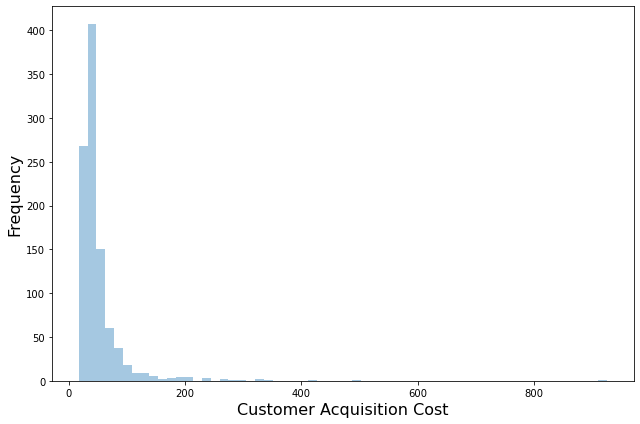

In [34]:
# Store simulation results in a dataframe
results_df = pd.DataFrame()
results_df['CLTV'] = CLTV_list
results_df['CAC'] = CAC_list
results_df['Spread'] = results_df['CLTV'] - results_df['CAC']

plot_df = results_df[results_df['CAC']<=1000]

# Histogram for distribution of customer acquisition cost
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(plot_df['CAC'], kde=False, bins=60)

ax.set_xlabel("Customer Acquisition Cost",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.tight_layout()

plt.savefig(fname='CAC_hist', dpi=150)
plt.show()

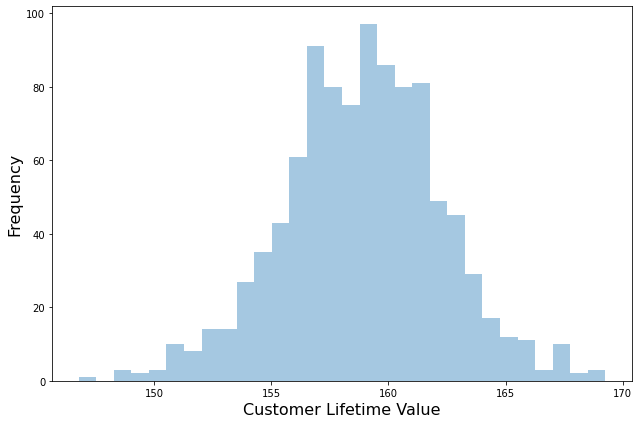

In [35]:
# Histogram for distribution of customer lifetime value
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(plot_df['CLTV'], kde=False, bins=30)

ax.set_xlabel("Customer Lifetime Value",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.tight_layout()

plt.savefig(fname='CLTV_hist', dpi=150)
plt.show()

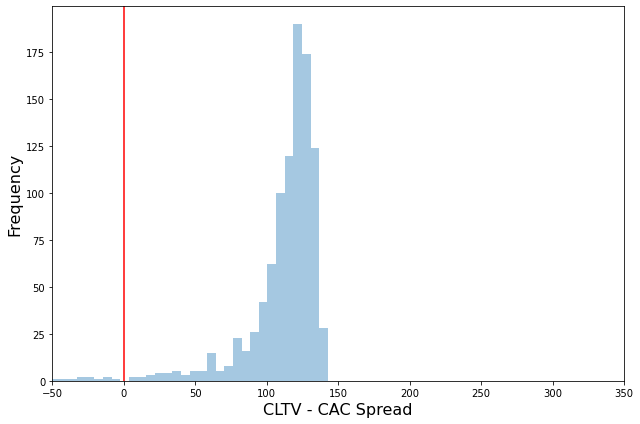

In [36]:
# Histogram for distribution of CLTV-CAC Spread
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(plot_df['Spread'], kde=False, bins=150)
plt.axvline(x=0, color='red')
plt.xlim(-50, 350)

ax.set_xlabel("CLTV - CAC Spread",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.tight_layout()

plt.savefig(fname='spread_hist', dpi=150)
plt.show()

In [ ]:
# Here we can see, based on the parameters set, that we have a very healthy profit margin when looking at the lifetime value of the customers less the acquisition costs across a large portion of the distribution. 
# Given this information it would be in the company's best interest to proceed with the marketing campaign. 
# Additionally, it would be good for you to help pressure test the sensitivity of these input variables against the project profit to see where things break down and communicate those risks to the business.